In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("MyApp") \
            .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.11.1") \
            .getOrCreate()

:: loading settings :: url = jar:file:/workspace/apache-spark-ml/.venv/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-30de0661-0063-4b3f-b465-d7902dacf2fb;1.0
	confs: [default]
	found com.microsoft.azure#synapseml_2.12;0.11.1 in central
	found com.microsoft.azure#synapseml-core_2.12;0.11.1 in central
	found org.scalactic#scalactic_2.12;3.2.14 in central
	found org.scala-lang#scala-reflect;2.12.15 in central
	found io.spray#spray-json_2.12;1.3.5 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents.client5#httpclient5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5-h2;5.1.3 in central
	found org.slf4j#slf4j-api;1.7.25 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpmime;4.5.13 in central
	found org.apache.httpcomponents#ht

In [2]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

cancer = load_breast_cancer()
cancer_columns = cancer.feature_names
cancer_pdf = pd.DataFrame(cancer.data, columns=cancer_columns)
cancer_pdf['label'] = cancer.target
cancer_sdf = spark.createDataFrame(cancer_pdf)
cancer_sdf.show()

23/06/07 09:06:56 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+-----+
|mean radius|mean texture|mean perimeter|mean area|mean smoothness|mean compactness|mean concavity|mean concave points|mean symmetry|mean fractal dimension|radius error|texture error|perimeter error|area error|smoothness error|compactness error|concavity error|concave points error|symmetry error|fractal dimension error|worst radius|worst texture|worst perimeter|worst area|worst smoothness|worst compactness|worst concavity|worst concave points|worst symmetry|worst fractal dimension|label|
+-----------+-

In [3]:
cancer_sdf.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  212|
|    1|  357|
+-----+-----+



### XGBoost

In [4]:
from pyspark.ml.feature import VectorAssembler

vectorized_sdf = VectorAssembler(inputCols=cancer_columns, outputCol='features').transform(cancer_sdf)
train_sdf, test_sdf = vectorized_sdf.randomSplit([0.8, 0.2], seed=2021)

In [5]:
from xgboost.spark import SparkXGBClassifier

xgb_classifier = SparkXGBClassifier(num_workers=4, missing=0.0)
xgb_model = xgb_classifier.fit(train_sdf)
xgb_predictions = xgb_model.transform(test_sdf)
xgb_predictions.show()

[09:07:15] task 3 got new rank 0                                    (0 + 4) / 4]
[09:07:15] task 1 got new rank 1
[09:07:15] task 2 got new rank 2
[09:07:16] task 0 got new rank 3
/workspace/apache-spark-ml/.venv/lib/python3.8/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+-----+--------------------+--------------------+----------+--------------------+
|mean radius|mean texture|mean perimeter|mean area|mean smoothness|mean compactness|mean concavity|mean concave points|mean symmetry|mean fractal dimension|radius error|texture error|perimeter error|area error|smoothness error|compactness error|concavity error|concave points error|symmetry error|fractal dimension error|worst radius|worst texture|worst perimeter|worst area|worst smoothness|worst compactness|worst concavity|worst c

In [6]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

acc_eval = MulticlassClassificationEvaluator(metricName='accuracy')
roc_eval = BinaryClassificationEvaluator()
accuracy = acc_eval.evaluate(xgb_predictions)
roc_auc = roc_eval.evaluate(xgb_predictions)

accuracy, roc_auc 

(0.954954954954955, 0.9866013071895425)

In [7]:
xgb_classifier = SparkXGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, num_workers=3, missing=0.0, verbosity=1)
xgb_model = xgb_classifier.fit(train_sdf)
xgb_predictions = xgb_model.transform(test_sdf)

[09:07:43] task 1 got new rank 0                                    (0 + 3) / 3]
[09:07:43] task 2 got new rank 1
[09:07:43] task 0 got new rank 2


In [8]:
params = {k.name: v for k, v in xgb_classifier.extractParamMap().items()}
params

{'rawPredictionCol': 'rawPrediction',
 'probabilityCol': 'probability',
 'enable_sparse_data_optim': False,
 'features_cols': [],
 'predictionCol': 'prediction',
 'labelCol': 'label',
 'featuresCol': 'features',
 'objective': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': 0.0,
 'monotone_constraints': None,
 'n_estimators': 100,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_me

In [9]:
fi_dict = { int(k[1:]): v for k, v in xgb_model.get_feature_importances().items() }
cancer_column_dict = { i: c for i, c in enumerate(cancer_columns) }
col_fi_dict = { cancer_column_dict[fik]: fiv for fik, fiv in fi_dict.items()}
col_fi_dict

{'mean texture': 35.0,
 'mean area': 17.0,
 'mean smoothness': 16.0,
 'mean compactness': 10.0,
 'mean concavity': 8.0,
 'mean concave points': 23.0,
 'mean fractal dimension': 4.0,
 'radius error': 4.0,
 'texture error': 1.0,
 'area error': 27.0,
 'smoothness error': 9.0,
 'compactness error': 13.0,
 'concavity error': 3.0,
 'concave points error': 3.0,
 'symmetry error': 8.0,
 'fractal dimension error': 3.0,
 'worst radius': 11.0,
 'worst texture': 41.0,
 'worst perimeter': 22.0,
 'worst area': 45.0,
 'worst smoothness': 18.0,
 'worst compactness': 1.0,
 'worst concavity': 35.0,
 'worst concave points': 32.0,
 'worst symmetry': 24.0,
 'worst fractal dimension': 12.0}

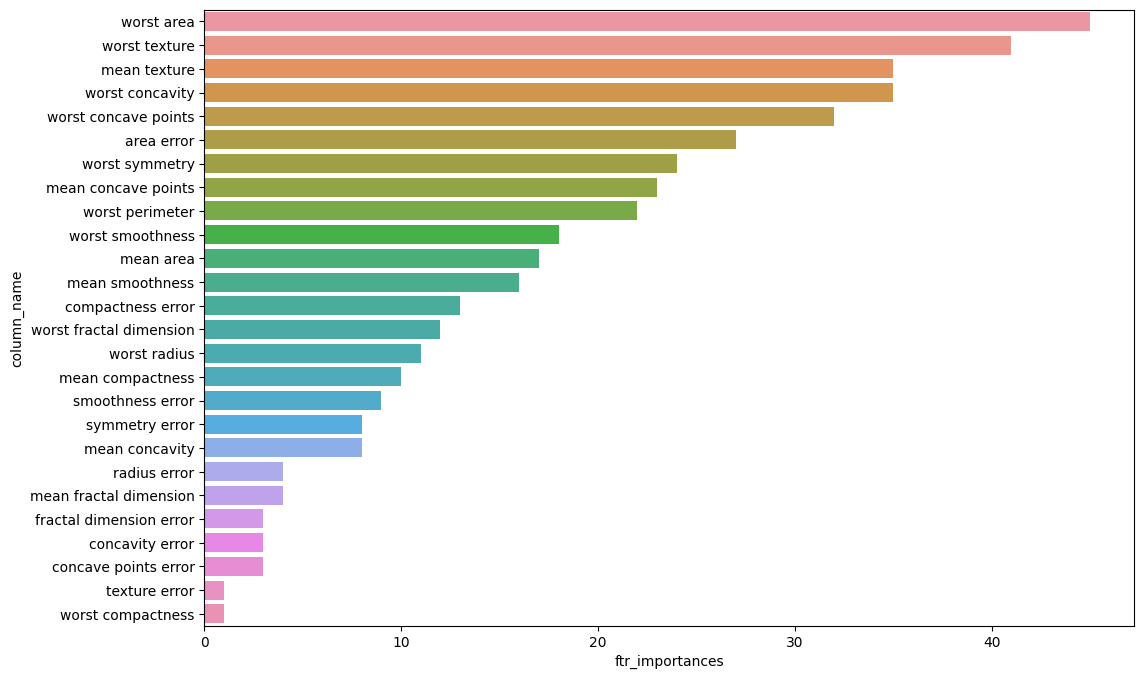

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.figure(figsize=(12, 8))
ftr_df = pd.DataFrame({'ftr_importances':col_fi_dict.values()
                      , 'column_name': col_fi_dict.keys()})
ftr_df = ftr_df.sort_values(by='ftr_importances', ascending=False)
sns.barplot(data=ftr_df, x='ftr_importances', y='column_name')
plt.show()

In [11]:
import pyspark.sql.functions as F

tr_sdf, val_sdf = train_sdf.randomSplit([0.8, 0.2], seed=2021)
tr_sdf = tr_sdf.withColumn('isVal', F.lit(False))
val_sdf = val_sdf.withColumn('isVal', F.lit(True))
tr_val_sdf = tr_sdf.union(val_sdf)
tr_val_sdf.show()
train_sdf.count(), tr_sdf.count(), val_sdf.count(), tr_val_sdf.count()

+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+-----+--------------------+-----+
|mean radius|mean texture|mean perimeter|mean area|mean smoothness|mean compactness|mean concavity|mean concave points|mean symmetry|mean fractal dimension|radius error|texture error|perimeter error|area error|smoothness error|compactness error|concavity error|concave points error|symmetry error|fractal dimension error|worst radius|worst texture|worst perimeter|worst area|worst smoothness|worst compactness|worst concavity|worst concave points|worst symmetry|worst fractal dime

(458, 375, 83, 458)

In [12]:
xgb_classifier = SparkXGBClassifier(n_estimator=100, learning_rate=0.1, 
                                    max_depth=3, validation_indicator_col='isVal',
                                    early_stopping_rounds=10, eval_metric='logloss',
                                    num_workers=3, missing=0.0)
xgb_model = xgb_classifier.fit(tr_val_sdf)
xgb_predictions = xgb_model.transform(test_sdf)

[09:08:05] task 1 got new rank 0                                    (0 + 3) / 3]
[09:08:06] task 2 got new rank 1
[09:08:06] task 0 got new rank 2
[09:08:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[09:08:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.
[09:08:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimator" } are not used.


[0]	training-logloss:0.60822	validation-logloss:0.61608
[1]	training-logloss:0.53820	validation-logloss:0.55489
[2]	training-logloss:0.47961	validation-logloss:0.50242
[3]	training-logloss:0.42994	validation-logloss:0.46016
[4]	training-logloss:0.38687	validation-logloss:0.42143
[5]	training-logloss:0.35020	validation-logloss:0.38926
[6]	training-logloss:0.31784	validation-logloss:0.36062
[7]	training-logloss:0.28964	validation-logloss:0.33612
[8]	training-logloss:0.26496	validation-logloss:0.31508
[9]	training-logloss:0.24326	validation-logloss:0.29736
[10]	training-logloss:0.22

In [13]:
from pyspark.ml.functions import vector_to_array
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(predictions_sdf, label_column='label'):
    predictions_pdf = predictions_sdf.select(label_column,'prediction',
                                            vector_to_array('probability')[0].alias('probability_0'),
                                            vector_to_array('probability')[1].alias('probability_1')
                                            ).toPandas()
    label = predictions_pdf[label_column].values
    prediction = predictions_pdf['prediction'].values
    probability_1 = predictions_pdf['probability_1'].values
    cm = confusion_matrix(label, prediction)
    accuracy = accuracy_score(label, prediction)
    precision = precision_score(label, prediction)
    recall = recall_score(label, prediction)
    f1 = f1_score(label, prediction)
    roc_auc = roc_auc_score(label, probability_1)
    print('confusion matrix:\n', cm)
    print(f'accuracy: {accuracy:.4f}, precision: {precision:.4f}, recall: {recall:.4f}, f1: {f1:.4f}, roc_auc: {roc_auc:.4f}')

In [82]:
get_clf_eval(xgb_predictions)

confusion matrix:
 [[47  4]
 [ 4 56]]
accuracy: 0.9279, precision: 0.9333, recall: 0.9333, f1: 0.9333, roc_auc: 0.9797


### LightGBM

In [29]:
from synapse.ml.lightgbm import LightGBMClassifier

In [33]:
lgbm_classifier = LightGBMClassifier(numLeaves=100, maxDepth=10, numIterations=100)
lgbm_model = lgbm_classifier.fit(train_sdf)
lgbm_predictions = lgbm_model.transform(test_sdf)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [34]:
get_clf_eval(lgbm_predictions)

confusion matrix:
 [[44  7]
 [ 1 59]]
accuracy: 0.9279, precision: 0.8939, recall: 0.9833, f1: 0.9365, roc_auc: 0.9863


In [35]:
params = {k.name: v for k, v in lgbm_classifier.extractParamMap().items()}
params

{'baggingFraction': 1.0,
 'baggingFreq': 0,
 'baggingSeed': 3,
 'binSampleCount': 200000,
 'boostFromAverage': True,
 'boostingType': 'gbdt',
 'catSmooth': 10.0,
 'categoricalSlotIndexes': [],
 'categoricalSlotNames': [],
 'catl2': 10.0,
 'chunkSize': 10000,
 'dataRandomSeed': 1,
 'defaultListenPort': 12400,
 'deterministic': False,
 'driverListenPort': 0,
 'dropRate': 0.1,
 'dropSeed': 4,
 'earlyStoppingRound': 0,
 'executionMode': 'bulk',
 'extraSeed': 6,
 'featureFraction': 1.0,
 'featureFractionSeed': 2,
 'featuresCol': 'features',
 'featuresShapCol': '',
 'improvementTolerance': 0.0,
 'isEnableSparse': True,
 'isProvideTrainingMetric': False,
 'isUnbalance': False,
 'labelCol': 'label',
 'lambdaL1': 0.0,
 'lambdaL2': 0.0,
 'leafPredictionCol': '',
 'learningRate': 0.1,
 'matrixType': 'auto',
 'maxBin': 255,
 'maxBinByFeature': [],
 'maxCatThreshold': 32,
 'maxCatToOnehot': 4,
 'maxDeltaStep': 0.0,
 'maxDepth': 10,
 'maxDrop': 50,
 'maxNumClasses': 100,
 'maxStreamingOMPThreads': 1

In [37]:
for col, importance in zip(cancer_columns, lgbm_model.getFeatureImportances()):
    print(f'{col}: {importance}')

mean radius: 49.0
mean texture: 197.0
mean perimeter: 41.0
mean area: 25.0
mean smoothness: 74.0
mean compactness: 44.0
mean concavity: 42.0
mean concave points: 135.0
mean symmetry: 17.0
mean fractal dimension: 61.0
radius error: 21.0
texture error: 53.0
perimeter error: 21.0
area error: 71.0
smoothness error: 31.0
compactness error: 31.0
concavity error: 15.0
concave points error: 14.0
symmetry error: 30.0
fractal dimension error: 22.0
worst radius: 99.0
worst texture: 145.0
worst perimeter: 149.0
worst area: 105.0
worst smoothness: 129.0
worst compactness: 47.0
worst concavity: 84.0
worst concave points: 193.0
worst symmetry: 107.0
worst fractal dimension: 27.0


<Axes: xlabel='ft_importances', ylabel='column_name'>

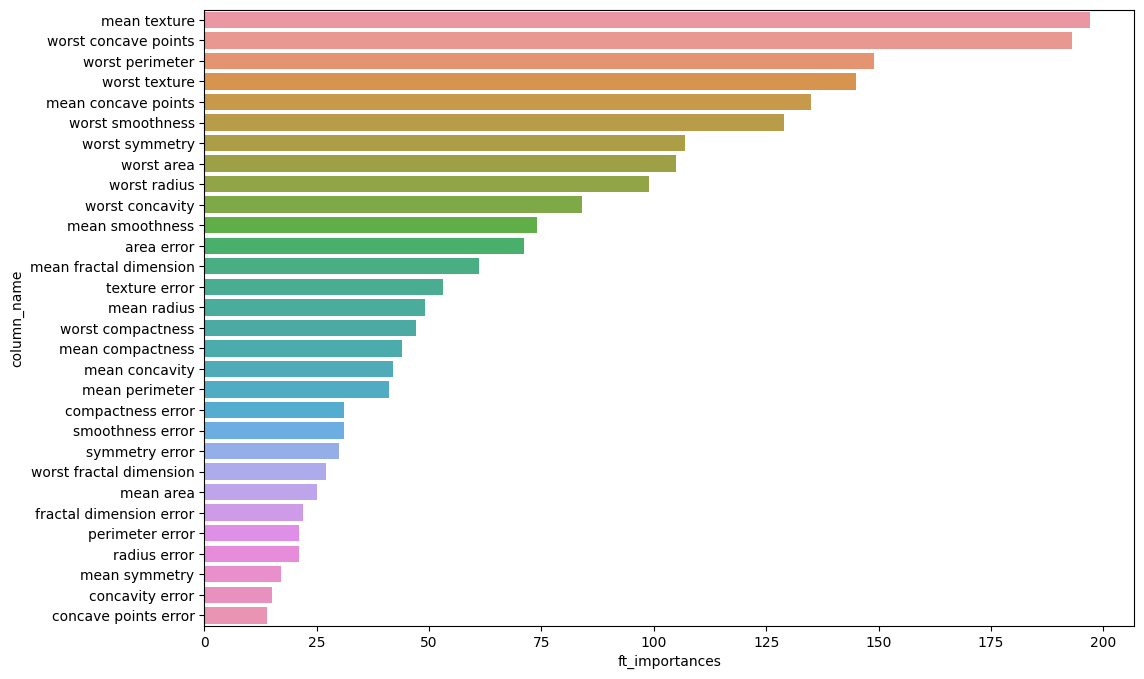

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
ft_importance_df = pd.DataFrame({'ft_importances': lgbm_model.getFeatureImportances(), 'column_name': cancer_columns})
ft_importance_df = ft_importance_df.sort_values(by='ft_importances', ascending=False)
sns.barplot(x=ft_importance_df['ft_importances'], y=ft_importance_df['column_name'])


In [41]:
lgbm_classifier = LightGBMClassifier(
    validationIndicatorCol='isVal',
    numLeaves=100,
    maxDepth=10,
    numIterations=100,
    earlyStoppingRound=10
)
lgbm_model = lgbm_classifier.fit(tr_val_sdf)
lgbm_predictions = lgbm_model.transform(test_sdf)

23/06/07 07:32:11 WARN BulkPartitionTask: LightGBM task encountered empty partition, for best performance ensure no partitions are empty
23/06/07 07:32:11 WARN BulkPartitionTask: LightGBM task encountered empty partition, for best performance ensure no partitions are empty
23/06/07 07:32:11 WARN BulkPartitionTask: LightGBM task encountered empty partition, for best performance ensure no partitions are empty
23/06/07 07:32:11 WARN BulkPartitionTask: LightGBM task encountered empty partition, for best performance ensure no partitions are empty
23/06/07 07:32:11 WARN BulkPartitionTask: LightGBM task encountered empty partition, for best performance ensure no partitions are empty
23/06/07 07:32:11 WARN BulkPartitionTask: LightGBM task encountered empty partition, for best performance ensure no partitions are empty
23/06/07 07:32:11 WARN BulkPartitionTask: LightGBM task encountered empty partition, for best performance ensure no partitions are empty
23/06/07 07:32:11 WARN BulkPartitionTask:

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [42]:
get_clf_eval(lgbm_predictions)

confusion matrix:
 [[46  5]
 [ 0 60]]
accuracy: 0.9550, precision: 0.9231, recall: 1.0000, f1: 0.9600, roc_auc: 0.9837
